# Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Using TensorFlow backend.


In [17]:
import math
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from timeit import default_timer as timer

# Data Examination

In [4]:
figsize=(20, 5)
plt.style.use('ggplot')

In [5]:
data = pd.read_csv('international-airline-passengers.csv', usecols=[1], engine='python', skipfooter=3)

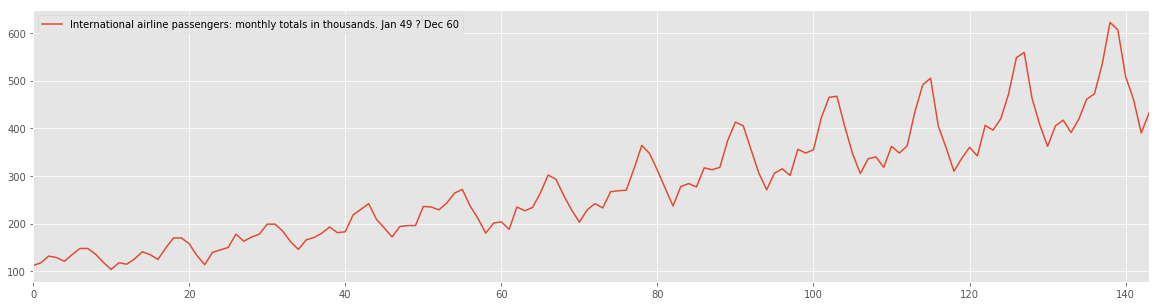

In [6]:
data.plot(figsize=figsize)

In [7]:
dataset = data.values
dataset = dataset.astype('float32')

In [8]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
scale_dataset = scaler.fit_transform(dataset)

In [9]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

# Train Loop

In [18]:
class TrainContext(object):
    def __init__(self, model, dataset, trainX, trainY, testX, testY, history):
        self.model = model
        self.dataset = dataset
        self.trainX = trainX
        self.trainY = trainY
        self.testX = testX
        self.testY = testY
        self.history = history
    
def train_model(dataset, look_back):
    # split into train and test sets
    train_size = int(len(dataset) * 0.67)
    test_size = len(dataset) - train_size
    train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

    # reshape into X=t and Y=t+1
    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)

    # reshape input to be [samples, time steps, features]
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
    
    # create and fit the LSTM network
    model = Sequential()
    model.add(LSTM(4, input_shape=(1, look_back)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    start = timer()
    history = model.fit(trainX, trainY, epochs=32, batch_size=1, verbose=0)
    end = timer()
    
    print("trained in ", end-start)
    
    return TrainContext(model, dataset, trainX, trainY, testX, testY, history)

# Train With Scaling

In [19]:
scaled = train_model(scale_dataset, 1)

trained in  40.73130429499997


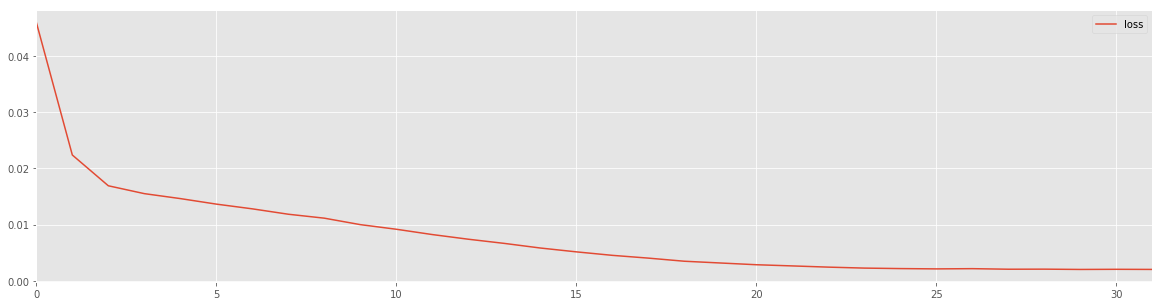

In [24]:
pd.DataFrame({"loss": scaled.history.history['loss']}).plot(figsize=figsize)

# Train Without Scaling

In [25]:
unscaled = train_model(dataset, 1)

trained in  40.661748934000116


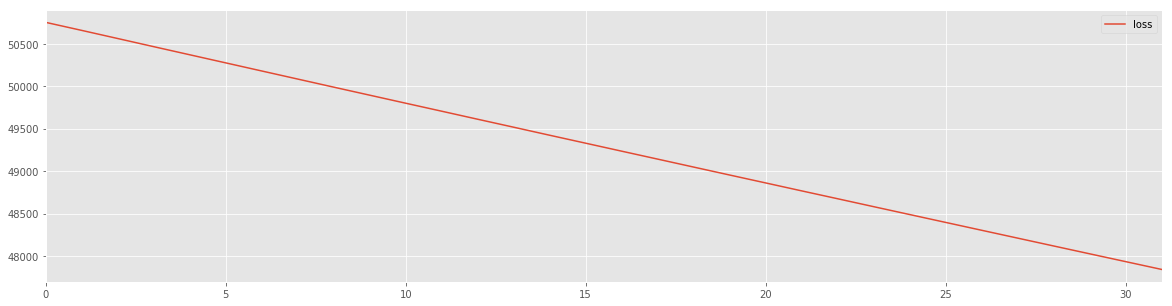

In [26]:
pd.DataFrame({"loss": unscaled.history.history['loss']}).plot(figsize=figsize)

# Evaluate

In [27]:
def plot_predict(ctx, look_back):
    # make predictions
    trainPredict = ctx.model.predict(ctx.trainX)
    testPredict = ctx.model.predict(ctx.testX)

    # invert predictions
    trainPredict = scaler.inverse_transform(trainPredict)
    trainY = scaler.inverse_transform([ctx.trainY])
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform([ctx.testY])

    dataset = ctx.dataset
    # shift train predictions for plotting
    trainPredictPlot = np.empty_like(dataset)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
    # shift test predictions for plotting
    testPredictPlot = np.empty_like(dataset)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
    
    # plot baseline and predictions
    plt.plot(scaler.inverse_transform(dataset))
    plt.plot(trainPredictPlot)
    plt.plot(testPredictPlot)
    plt.show()

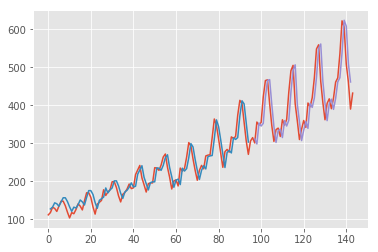

In [28]:
plot_predict(scaled, 1)

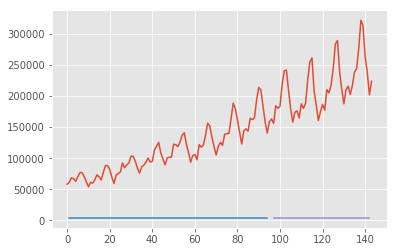

In [29]:
plot_predict(unscaled, 1)

# Let's Explore Our SingGen

In [30]:
type(unscaled.dataset)

numpy.ndarray

In [31]:
unscaled.dataset.shape

(144, 1)

In [32]:
from singen import SinP1Gen

In [33]:
g = SinP1Gen(timesteps=144)

In [34]:
x, y = g.batch()

In [35]:
xdata = x.squeeze(axis=0)
xdata.shape

(144, 1)

### Rerun with this new data

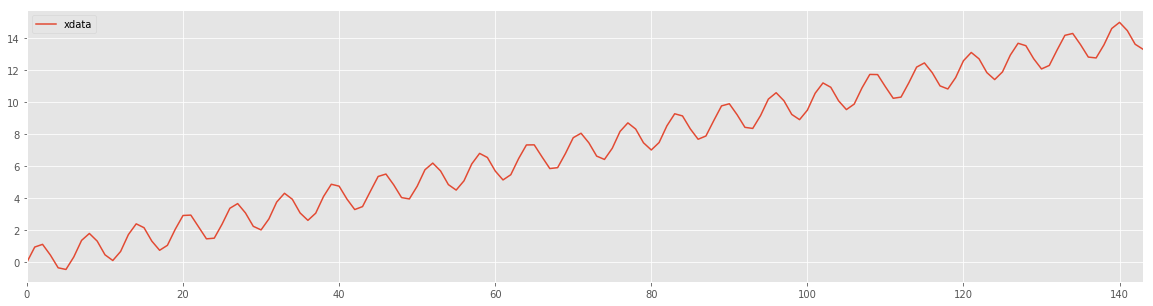

In [36]:
pd.DataFrame({"xdata": xdata.squeeze()}).plot(figsize=figsize)

In [37]:
xdata_scale = scaler.fit_transform(xdata)

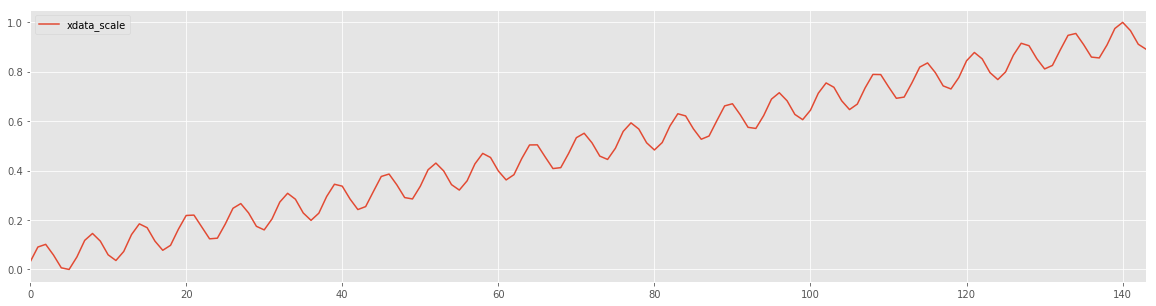

In [38]:
pd.DataFrame({"xdata_scale": xdata_scale.squeeze()}).plot(figsize=figsize)

In [39]:
xctx = train_model(xdata_scale, 1)

trained in  40.40299634200005


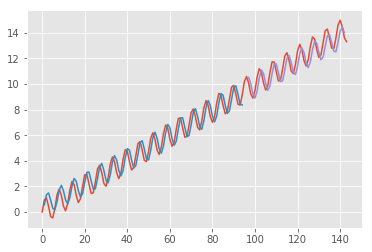

In [40]:
plot_predict(xctx, 1)

In [41]:
help(MinMaxScaler)

Help on class MinMaxScaler in module sklearn.preprocessing.data:

class MinMaxScaler(sklearn.base.BaseEstimator, sklearn.base.TransformerMixin)
 |  Transforms features by scaling each feature to a given range.
 |  
 |  This estimator scales and translates each feature individually such
 |  that it is in the given range on the training set, i.e. between
 |  zero and one.
 |  
 |  The transformation is given by::
 |  
 |      X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
 |      X_scaled = X_std * (max - min) + min
 |  
 |  where min, max = feature_range.
 |  
 |  This transformation is often used as an alternative to zero mean,
 |  unit variance scaling.
 |  
 |  Read more in the :ref:`User Guide <preprocessing_scaler>`.
 |  
 |  Parameters
 |  ----------
 |  feature_range : tuple (min, max), default=(0, 1)
 |      Desired range of transformed data.
 |  
 |  copy : boolean, optional, default True
 |      Set to False to perform inplace row normalization and avoid a
 |   

### first, what is up with this shape?

In [42]:
xctx.trainX.shape

(94, 1, 1)

In [43]:
xctx.trainX.squeeze()[0:10]

array([ 0.02972468,  0.09070409,  0.10157426,  0.05829618,  0.00661446,
        0.        ,  0.05048905,  0.11761718,  0.14562204,  0.11471105])

In [44]:
xctx.trainY.squeeze()[0:10]

array([ 0.09070409,  0.10157426,  0.05829618,  0.00661446,  0.        ,
        0.05048905,  0.11761718,  0.14562204,  0.11471105,  0.0592586 ])

## Implement the scaling factor

In [45]:
import tensorflow as tf

In [46]:
help(tf.nn.l2_normalize)

Help on function l2_normalize in module tensorflow.python.ops.nn_impl:

l2_normalize(x, dim, epsilon=1e-12, name=None)
    Normalizes along dimension `dim` using an L2 norm.
    
    For a 1-D tensor with `dim = 0`, computes
    
        output = x / sqrt(max(sum(x**2), epsilon))
    
    For `x` with more dimensions, independently normalizes each 1-D slice along
    dimension `dim`.
    
    Args:
      x: A `Tensor`.
      dim: Dimension along which to normalize.  A scalar or a vector of
        integers.
      epsilon: A lower bound value for the norm. Will use `sqrt(epsilon)` as the
        divisor if `norm < sqrt(epsilon)`.
      name: A name for this operation (optional).
    
    Returns:
      A `Tensor` with the same shape as `x`.



In [47]:
sess = tf.InteractiveSession()
op = tf.nn.l2_normalize(xdata, 0)
xdata_l2 = op.eval()
sess.close()

In [48]:
xdata_scale.squeeze()[0:10]

array([ 0.02972468,  0.09070409,  0.10157426,  0.05829618,  0.00661446,
        0.        ,  0.05048905,  0.11761718,  0.14562204,  0.11471105])

In [49]:
xdata_l2.squeeze()[0:10]

array([ 0.        ,  0.00945934,  0.01114556,  0.00443211, -0.00358494,
       -0.004611  ,  0.00322104,  0.0136342 ,  0.01797841,  0.01318339])

## Implement this ourselves to get the value

In [50]:
def scale_data(data, dim, epsilon=1e-12):
    with tf.Session() as sess:
        tdata = tf.convert_to_tensor(data)
        square_sum = tf.reduce_sum(tf.square(tdata), dim, keep_dims=True)
        x_inv_norm = tf.rsqrt(tf.maximum(square_sum, epsilon))
        res = tf.multiply(x, x_inv_norm)
        out, inv_norm = sess.run([res, x_inv_norm])
    return out, inv_norm

In [51]:
d, i = scale_data(xdata, 0)

In [52]:
d.squeeze()[0:10]

array([ 0.        ,  0.00945934,  0.01114556,  0.00443211, -0.00358494,
       -0.004611  ,  0.00322104,  0.0136342 ,  0.01797841,  0.01318339])

In [53]:
i

array([[ 0.01004741]])

In [54]:
xdata_l2.squeeze()[0:10]

array([ 0.        ,  0.00945934,  0.01114556,  0.00443211, -0.00358494,
       -0.004611  ,  0.00322104,  0.0136342 ,  0.01797841,  0.01318339])

In [55]:
(xdata * i.squeeze()).squeeze()[0:10]

array([ 0.        ,  0.00945934,  0.01114556,  0.00443211, -0.00358494,
       -0.004611  ,  0.00322104,  0.0136342 ,  0.01797841,  0.01318339])

# Train TF Model

In [57]:
len(xdata_scale)

144

In [58]:
xdata_scale.shape

(144, 1)

In [59]:
x.shape

(1, 144, 1)

In [82]:
xscaled = scaler.fit_transform(x.squeeze(axis=0)).reshape(x.shape)

In [83]:
yscaled = scaler.fit_transform(y.squeeze(axis=0)).reshape(y.shape)

In [84]:
xscaled.shape

(1, 144, 1)

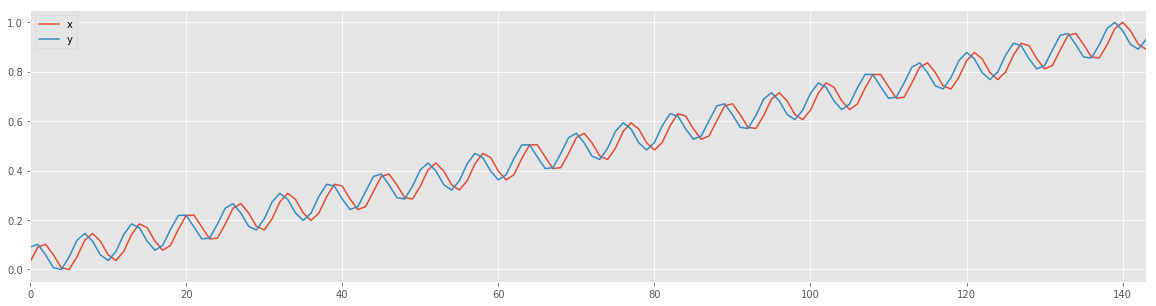

In [85]:
pd.DataFrame({"x": xscaled[0].squeeze(), "y": yscaled[0].squeeze()}).plot(figsize=figsize)

In [116]:
import basic_tf_p1 as b
# from importlib import reload
# reload(b)

<module 'basic_tf_p1' from '/Users/paulm/code/rnn/lstm/basic_tf_p1.py'>

In [126]:
class TFTrainContext(object):
    def __init__(self, model, dataset, trainX, trainY, testX, testY, losses):
        self.model = model
        self.dataset = dataset
        self.trainX = trainX
        self.trainY = trainY
        self.testX = testX
        self.testY = testY
        self.losses = losses
    
def tf_train_model(x, y, units, breadth, linear):
    # split into train and test sets
    timesteps = x.shape[1]
    train_size = int(timesteps * 0.67)
    test_size = timesteps - train_size
    trainX, testX = x[:,0:train_size,:], x[:,train_size:timesteps,:]
    trainY, testY = y[:, 0:train_size,:], y[:,train_size:timesteps,:]

    model = b.TSModel(name="notebook", units=units, timesteps=train_size, l2norm=False,
                      breadth=breadth, depth=1, linear=linear)
        
    start = timer()
    losses = model.fit(trainX, trainY, epochs=96, verbose=0)
    model.close()
    end = timer()
    
    print("trained in ", end-start)
    
    return TFTrainContext(model, dataset, trainX, trainY, testX, testY, losses)

In [127]:
models = {}
for units in [4, 8, 16, 32, 64]:
    for breadth in [2, 4, 8]:
        for linear in [1, 0]:
            name = "units_%d__breadth_%d__linear_%d" % (units, breadth, linear)
            print("training: ", name)
            tfctx = tf_train_model(xscaled, yscaled, units, breadth, linear)
            models[name] = tfctx.losses

training:  units_4__breadth_2__linear_1
trained in  36.3172371599976
training:  units_4__breadth_2__linear_0
trained in  34.22860691800088
training:  units_4__breadth_4__linear_1
trained in  60.89447702799953
training:  units_4__breadth_4__linear_0
trained in  68.40480646400101
training:  units_4__breadth_8__linear_1
trained in  127.9538063809996
training:  units_4__breadth_8__linear_0
trained in  130.82920620499863
training:  units_8__breadth_2__linear_1
trained in  40.67110348600181
training:  units_8__breadth_2__linear_0
trained in  38.417089227998076
training:  units_8__breadth_4__linear_1
trained in  75.67938857400077
training:  units_8__breadth_4__linear_0
trained in  74.574289305001
training:  units_8__breadth_8__linear_1
trained in  125.1989087380025
training:  units_8__breadth_8__linear_0
trained in  145.08352259499952
training:  units_16__breadth_2__linear_1
trained in  40.977421503001096
training:  units_16__breadth_2__linear_0
trained in  41.50658455500161
training:  units_

In [128]:
models.keys()

dict_keys(['units_4__breadth_2__linear_1', 'units_4__breadth_2__linear_0', 'units_4__breadth_4__linear_1', 'units_4__breadth_4__linear_0', 'units_4__breadth_8__linear_1', 'units_4__breadth_8__linear_0', 'units_8__breadth_2__linear_1', 'units_8__breadth_2__linear_0', 'units_8__breadth_4__linear_1', 'units_8__breadth_4__linear_0', 'units_8__breadth_8__linear_1', 'units_8__breadth_8__linear_0', 'units_16__breadth_2__linear_1', 'units_16__breadth_2__linear_0', 'units_16__breadth_4__linear_1', 'units_16__breadth_4__linear_0', 'units_16__breadth_8__linear_1', 'units_16__breadth_8__linear_0', 'units_32__breadth_2__linear_1', 'units_32__breadth_2__linear_0', 'units_32__breadth_4__linear_1', 'units_32__breadth_4__linear_0', 'units_32__breadth_8__linear_1', 'units_32__breadth_8__linear_0', 'units_64__breadth_2__linear_1', 'units_64__breadth_2__linear_0', 'units_64__breadth_4__linear_1', 'units_64__breadth_4__linear_0', 'units_64__breadth_8__linear_1', 'units_64__breadth_8__linear_0'])

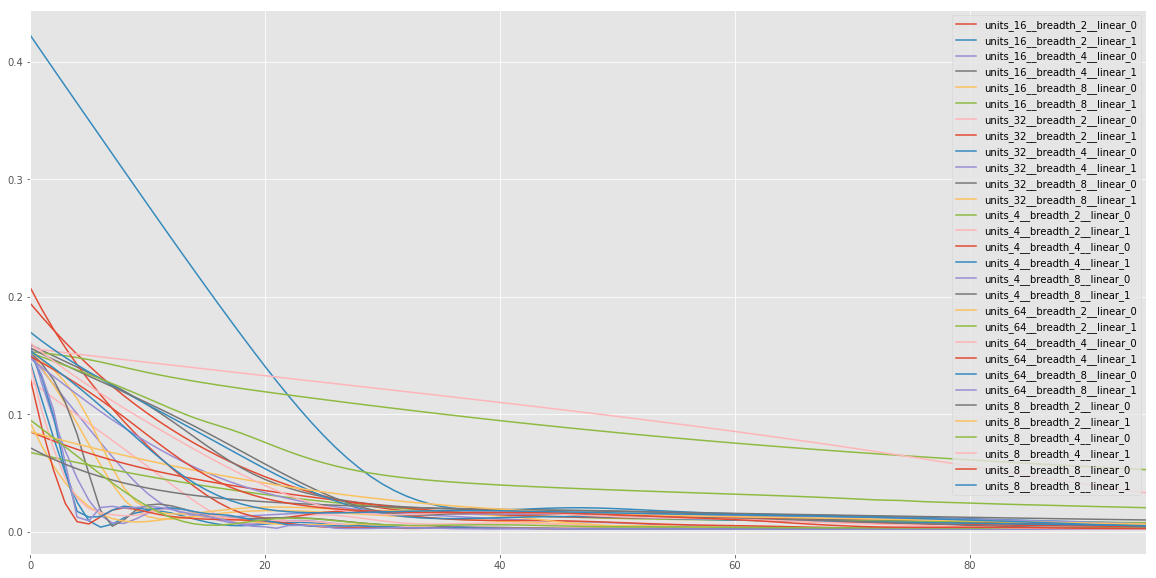

In [131]:
pd.DataFrame(models).plot(figsize=(20, 10))

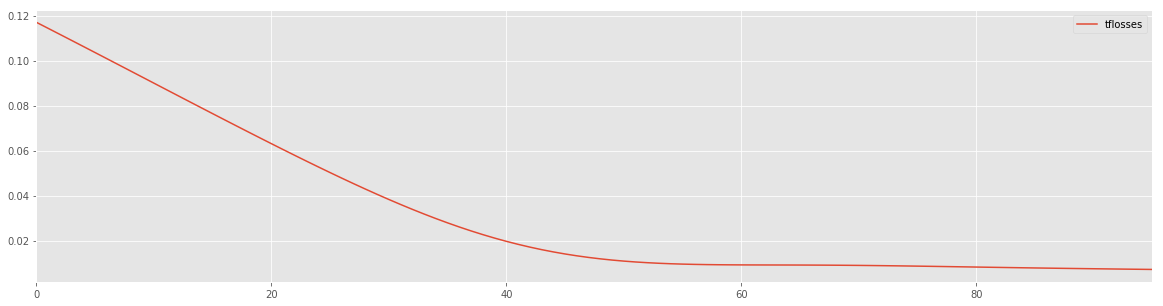

In [119]:
pd.DataFrame({"tflosses" : tfctx.losses}).plot(figsize=figsize)

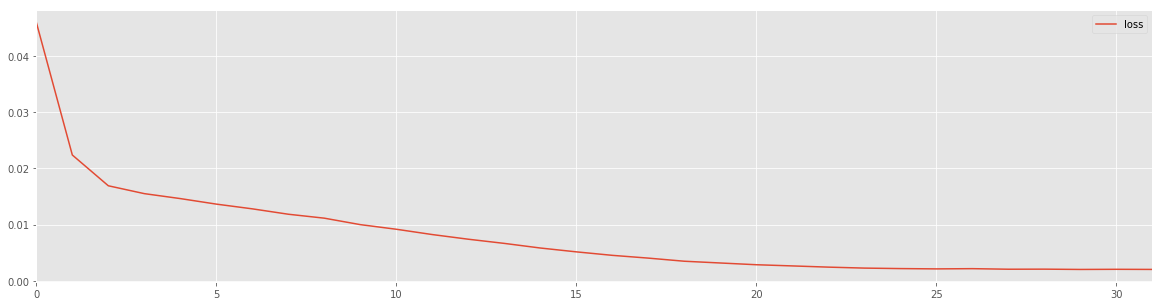

In [123]:
pd.DataFrame({"loss": scaled.history.history['loss']}).plot(figsize=figsize)

In [124]:
min(tfctx.losses)

0.0071791597

In [125]:
min(scaled.history.history['loss'])

0.0020502076635144726